# SI630: Final Project code for 3_ppl_mngmt classification task

***  


In [1]:
import os
import json, csv
import re

import pandas as pd
import spacy
import sklearn
from glob import glob
from pprint import pprint

#import pickle
from collections import Counter, defaultdict
import numpy as np
#from numpy import argmax
import scipy
import seaborn as sns
import matplotlib
import math
import random
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords 
set(stopwords.words('english'))   
#from numba import jit
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve


import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
monster_df = pd.read_excel("/Users/yukolopez/Desktop/SI630/Assignments/FinalProject/LR+LDA/monster_com-job_with_label_columns.csv.xlsx", 
                 error_bad_lines=False, sheet_name="monster_com-job_sample", na_filter=False, encoding= 'utf-8')

In [3]:
monster_df = monster_df.replace({'T':True, 'F':False, '':np.nan})

In [4]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # Remove Emails
    text = re.sub(r"\S*@\S*\s?", "", text)
    
    # Remove new line characters
    text = re.sub(r"\s+", " ", text)
    
    # Remove single quotes
    text = re.sub(r"\'", "", text)
    
    # Convert text to lowercase
    text = text.strip().lower()
    
    # Remove entity abbreviations
    # Add \b in redgex so that it creates word boundary -(e.g) the word, company, remains company.
    text = re.sub(r",?\s*\b(llc|inc|co)\b\.?", "", text)
    
    # Replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

#pprint(text)
    return text

#### If each company name is a string on its own, you can try the following regex: /,?\s*(llc|inc|co)\.?$/i --> 
Optional comma
Optional whitespace
Either one of LLC/Inc/Co (case-insensitive)
Optional period
All the above at the end of the string


In [5]:
labeled_rows = monster_df.loc[~monster_df['1_self_mngmt'].isnull()]

In [6]:
X = labeled_rows['job_description']
y = labeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]

***  

### Class Distribution Graph: 200 labed rows

In [7]:
import seaborn as sns; sns.set()
sns.set_color_codes()

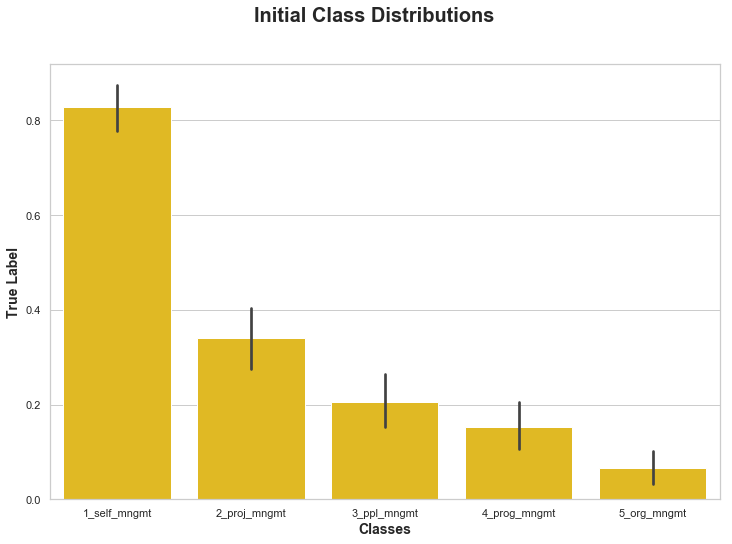

In [8]:
sns.set(style="whitegrid")
colors = ['#ffcb05', '#00274c']
# labels = y[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]
# fig, ax = plt.subplots(1, figsize=(12, 8))
# barplot = plt.bar(labels, height=1, color = 'darkgreen', alpha = 0.85)
# barplot[1].set_color('#00274c')

fig, ax = plt.subplots(1, figsize=(12, 8))
sns.barplot(data=y, color='#ffcb05')
plt.suptitle("Initial Class Distributions", fontsize=20, weight = 'bold')
plt.xlabel('Factors', fontsize = 15, weight = 'bold')
plt.xlabel('Classes', fontsize=14, weight = 'bold')
plt.ylabel('True Label', fontsize=14, weight = 'bold')
plt.show()

# The fraction of True shown
# Right now, I just don't know the true class distribution  --> Later to be addressed this class imbalance but not right now.

In [9]:
stopwords_lst = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

count_vectorizer = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=3, max_df=0.5)

# Fit and transform count_vectorizer: 
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)


# Similarly for IF-IDF:
tfidf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train_tf = tfidf_transformer.transform(X_train)
X_test_tf = tfidf_transformer.transform(X_test)

In [11]:
#count_vectorizer.vocabulary_

In [12]:
X_train

<144x1857 sparse matrix of type '<class 'numpy.int64'>'
	with 17237 stored elements in Compressed Sparse Row format>

In [13]:
X_test
X_test 

<71x1857 sparse matrix of type '<class 'numpy.int64'>'
	with 7844 stored elements in Compressed Sparse Row format>

In [14]:
y_train = y_train.astype('bool')

In [15]:
y_test = y_test.astype('bool')
y_test.mean()

1_self_mngmt    0.816901
2_proj_mngmt    0.352113
3_ppl_mngmt     0.183099
4_prog_mngmt    0.126761
5_org_mngmt     0.112676
dtype: float64

***  

# 4. Training The Model & Predicting

In [16]:
classifier = LogisticRegression(solver='lbfgs', class_weight='balanced').fit(X_train, y_train["3_ppl_mngmt"])

In [17]:
y_pred = classifier.predict(X_test) #Predict class labels for samples in X
y_pred

array([ True, False, False,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False])

In [18]:
classifier.predict_proba(X_test) #Probability estimates 

array([[2.89630084e-02, 9.71036992e-01],
       [5.50530606e-01, 4.49469394e-01],
       [8.63462413e-01, 1.36537587e-01],
       [3.68715857e-01, 6.31284143e-01],
       [7.42846046e-02, 9.25715395e-01],
       [9.94804625e-01, 5.19537458e-03],
       [9.53916046e-01, 4.60839536e-02],
       [4.89662966e-01, 5.10337034e-01],
       [9.79255334e-01, 2.07446663e-02],
       [9.80164525e-01, 1.98354747e-02],
       [7.61973766e-01, 2.38026234e-01],
       [9.79716114e-01, 2.02838857e-02],
       [7.03677460e-01, 2.96322540e-01],
       [9.53342810e-01, 4.66571902e-02],
       [8.93121934e-01, 1.06878066e-01],
       [9.25902962e-01, 7.40970378e-02],
       [9.97342736e-01, 2.65726401e-03],
       [9.99491233e-01, 5.08766573e-04],
       [4.47269737e-01, 5.52730263e-01],
       [2.88453474e-01, 7.11546526e-01],
       [9.55366758e-01, 4.46332421e-02],
       [8.70499611e-01, 1.29500389e-01],
       [5.80410011e-01, 4.19589989e-01],
       [8.74469106e-01, 1.25530894e-01],
       [7.004420

***  

### (1) Accuracy Score

In [19]:
accuracy_score = classifier.score(X_test, y_test["3_ppl_mngmt"])
accuracy_score
#X_test.shape #--> (9, 1306)
#y_test.shape #--> (16, 5)

# The accuracy score of the model

0.7887323943661971

***  

### (2) F1 Score

In [20]:
print(f1_score(y_test["3_ppl_mngmt"], y_pred, average='weighted'))  
print(f1_score(y_test["3_ppl_mngmt"], y_pred, average='macro'))  
print(f1_score(y_test["3_ppl_mngmt"], y_pred, average='micro'))  
# print(f1_score(y_test["3_ppl_mngmt"], y_pred, average='weighted'))

0.7854098952690503
0.6358974358974359
0.7887323943661971


***  

### (4) Cross Entropy

In [21]:
log_loss(y_test["3_ppl_mngmt"], y_pred, eps=1e-15)

7.297003424023544

***

### (5) ROC AUC Score 

In [22]:
# We need some probabilities:
predicted_prob = classifier.predict_proba(X_test)
roc_auc_score(y_test["3_ppl_mngmt"].astype(int), predicted_prob[:,1])
# -->0.8055555555555556 returns: Given the random prediction is 0.5, where 1.0 is perfect, any value above 0.5 is good.  
#This looks at the probabilities, and it will provide more fine-grained view of how the model is doing compared to acc score.  

0.7718832891246684

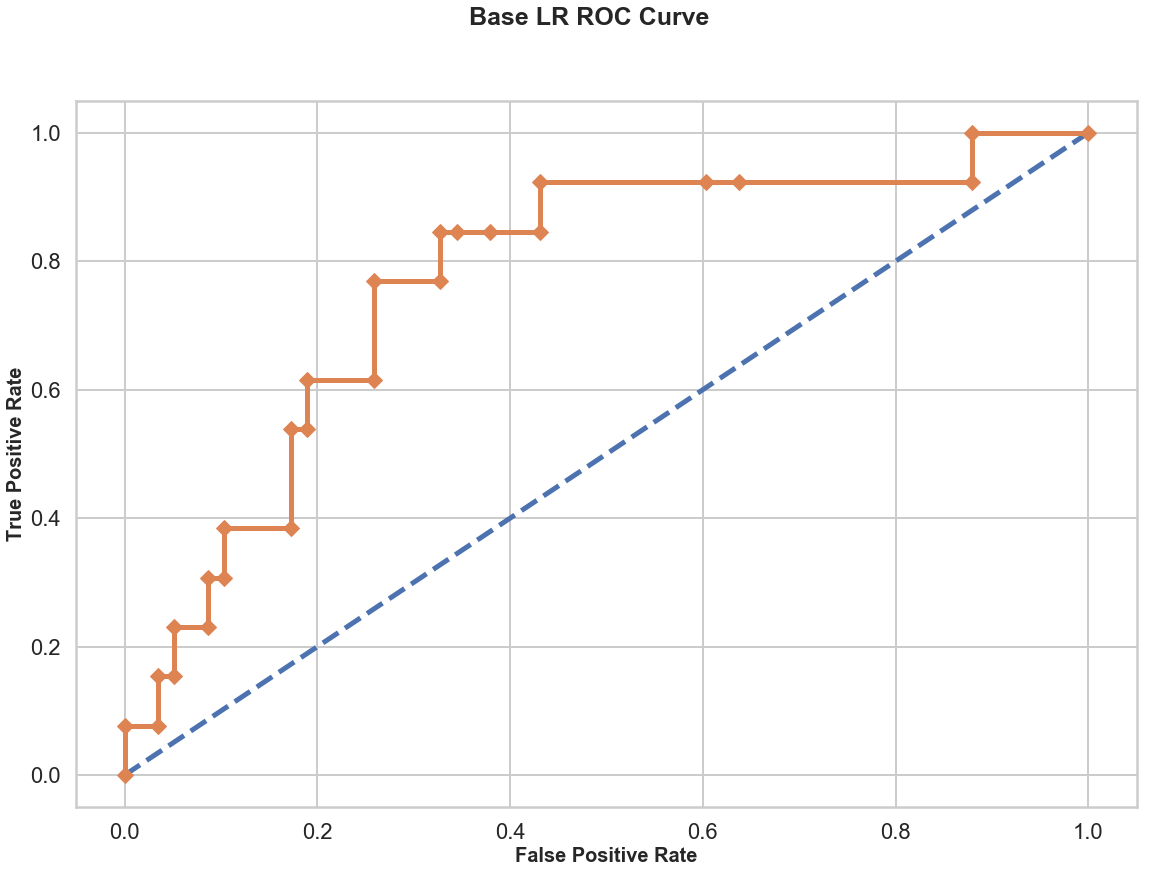

In [23]:
sns.set(style="whitegrid")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(19,13))

# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test["3_ppl_mngmt"].astype(int), predicted_prob[:,1])

plt.suptitle("Base LR ROC Curve", fontsize=25, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 20, weight = 'bold')
plt.ylabel('True Positive Rate', fontsize=20, weight = 'bold')

# The blue dotted diagonal line indicates randomness.
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=5)
# The solid orange line indictaes the roc curve for the model
plt.plot(fpr, tpr, marker='D', linewidth=5)

# show the plot
plt.show()

***  

### (6) Classification Report

In [24]:
target_names = ['False', 'True']
print(classification_report(y_test["3_ppl_mngmt"].astype(int), y_pred, target_names=target_names))

              precision    recall  f1-score   support

       False       0.86      0.88      0.87        58
        True       0.42      0.38      0.40        13

   micro avg       0.79      0.79      0.79        71
   macro avg       0.64      0.63      0.64        71
weighted avg       0.78      0.79      0.79        71



***  
### Baseline Results: Making predictions for unlabeled data

In [25]:
# Now we will find unlabeled rows for '2_proj_mngmt':
unlabeled_rows = monster_df.loc[monster_df['3_ppl_mngmt'].isnull()]
unlabeled_rows = unlabeled_rows.dropna(subset=["job_description"])

In [26]:
# Preproccessing
X_unlabeled = unlabeled_rows['job_description']
#y = unlabeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']] --> I don't need this.

In [27]:
X_unlabeled = count_vectorizer.transform(X_unlabeled)
X_unlabeled_tf = tfidf_transformer.transform(X_unlabeled)
#print(X_unlabeled_tf)
# print(X_unlabeled)

In [28]:
unlabeled_pred_result = classifier.predict_proba(X_unlabeled_tf)
unlabeled_pred_result #Probability estimates --> Look for the values, where the differece between x and y values are smallest
print(unlabeled_pred_result)

[[0.90823516 0.09176484]
 [0.89708058 0.10291942]
 [0.88760408 0.11239592]
 ...
 [0.9017094  0.0982906 ]
 [0.89711216 0.10288784]
 [0.88353819 0.11646181]]


In [29]:
unlabeled_rows["prob_false"] = unlabeled_pred_result[:,0]
unlabeled_rows["prob_true"] = unlabeled_pred_result[:,1]
unlabeled_rows["label_prob_diff"] = unlabeled_rows["prob_false"] - unlabeled_rows["prob_true"]
unlabeled_rows[["prob_false", "prob_true", "label_prob_diff"]].sort_values(by="label_prob_diff", ascending=False)
subset = unlabeled_rows[unlabeled_rows["label_prob_diff"].between(-100,100)] #Use func, between.
subset = subset[["prob_false", "prob_true", "label_prob_diff", "uniq_id" ]].sort_values(by="label_prob_diff", ascending=True)

***  

# 5. (1) Building Pipeline: Improve classification: LR with LDA
https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

In [30]:
X_labeled_text = labeled_rows['job_description'] #Text job desc3_ppl_mngmtriptions
y_labeled = labeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]

In [31]:
X_all = monster_df["job_description"].dropna()

In [35]:
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

# Define Search Param
search_params = {'n_components': [40, 45, 50], 'learning_decay': [0.7, 0.8, 0.9], 
                 'C': [0.85, 1.0]}

# For best_or_model, consider C=, 
# count_vectorizer_lda to be added to the search_params -(e.g.) min_df=100, max_df=0.7
grid = ParameterGrid(search_params)

#These are for lda model:
#Use BoW, not tfidf because BoW is the assumption that lda uses
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
X_bow = count_vectorizer_lda.fit_transform(X_all) # X_all = monster_df["job_description"].dropna()

for params in grid:
    best_lda_model = LatentDirichletAllocation(n_components=params['n_components'], 
                                               learning_decay=params['learning_decay'], 
                                               max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
    best_lda_model.fit(X_bow) # Fits the model on the entire dataset
    X_labeled = count_vectorizer_lda.transform(X_labeled_text) 
    # Take the above fitted data to take to the LR model.  To do so, first apply count_vectorizer and apply LDA model.
    X_labeled = best_lda_model.transform(X_labeled) 

    X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=42)
    # y_test['2_proj_mngmt']

    best_lr_model = LogisticRegression(penalty='l2', solver='lbfgs', C=params['C'], class_weight='balanced')
    best_lr_model.fit(X_train, y_train["3_ppl_mngmt"].astype(bool))
    y_pred = best_lr_model.predict(X_test) #Predict class labels for samples in X

    #cv_scores = cross_val_score(best_lr_model, X_test, y_pred, cv=2)
    
    cross_entropy = log_loss(y_test["3_ppl_mngmt"].astype(bool), y_pred, eps=1e-15)
    
    predicted_prob = best_lr_model.predict_proba(X_test)
    rocauc_score = roc_auc_score(y_test["3_ppl_mngmt"].astype(bool), predicted_prob[:,1])
    accuracy_score = best_lr_model.score(X_test, y_test["3_ppl_mngmt"].astype(bool))
    
    weighted_f1_score = f1_score(y_test["3_ppl_mngmt"].astype(bool), y_pred, average='weighted')  
    macro_f1_score = f1_score(y_test["3_ppl_mngmt"].astype(bool), y_pred, average='macro')  
    micro_f1_score = f1_score(y_test["3_ppl_mngmt"].astype(bool), y_pred, average='micro')
    
    print("Parameters: ", params,",", "\n"
          "Accuracy Score: ", accuracy_score,",", "\n"
          'F1 Weighted: ', weighted_f1_score, ",", "\n"
          'F1 Macro: ', macro_f1_score,",", "\n" 
          'F1 Micro: ', micro_f1_score, ",", "\n"
          'Log Loss: ', cross_entropy, ",", "\n"
          "ROC AUC: ", rocauc_score, "\n\n")
    

Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 40} , 
Accuracy Score:  0.7464788732394366 , 
F1 Weighted:  0.7697315971299494 , 
F1 Macro:  0.6650943396226414 , 
F1 Micro:  0.7464788732394367 , 
Log Loss:  8.756467175667817 , 
ROC AUC:  0.8050397877984085 


Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 45} , 
Accuracy Score:  0.7464788732394366 , 
F1 Weighted:  0.771882305981639 , 
F1 Macro:  0.6766194331983806 , 
F1 Micro:  0.7464788732394367 , 
Log Loss:  8.756478437603455 , 
ROC AUC:  0.8381962864721486 


Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 50} , 
Accuracy Score:  0.8028169014084507 , 
F1 Weighted:  0.8124413145539907 , 
F1 Macro:  0.7041666666666666 , 
F1 Micro:  0.8028169014084506 , 
Log Loss:  6.8105643085298775 , 
ROC AUC:  0.8050397877984086 


Parameters:  {'C': 0.85, 'learning_decay': 0.8, 'n_components': 40} , 
Accuracy Score:  0.7183098591549296 , 
F1 Weighted:  0.7465358955351541 , 
F1 Macro:  0.6406882591093


***  

# 5. (2) Applying the best LDA parameters and display topics

In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

X_all = monster_df["job_description"].dropna()

# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.
#count_vectorizer_lda = CountVectorizer(stop_words="english", preprocessor=clean_text, min_df=100, max_df=0.5)
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
# LDA is unsupervised, which means no label required.  

X_bow = count_vectorizer_lda.fit_transform(X_all) # X came from X = labeled_rows['job_description']
# X_tfidf = tfidf_transformer.fit_transform(X_bow)

X_bow_feature_names = count_vectorizer_lda.get_feature_names()

lda = LatentDirichletAllocation(n_components=50, learning_decay=0.9, max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)

lda.fit(X_bow) 


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.9, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=100,
             mean_change_tol=0.001, n_components=50, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [33]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 15
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, X_bow_feature_names, num_top_words)

Topic 0:
patient care patients nursing required needs certification assigned hospital appropriate procedures plan provides treatment staff
Topic 1:
data job network services business centurylink programmer company communications solutions technology video voice designed employees
Topic 2:
security apply whelan requirements team must background following one education least assessment meet candidates law
Topic 3:
accounting financial accounts finance job monthly reporting analysis years degree accountant responsibilities excel reports general
Topic 4:
company years candidate position please looking opportunity resume client candidates must seeking benefits team ideal
Topic 5:
project construction projects management manager engineering design job contract site schedule cost field manage quality
Topic 6:
center england children education career driver behavioral training truck child families social mental classroom school
Topic 7:
services solutions com clients companies www global us bu

***  

## Possible Interview Questions for 3_ppl_mngmt

In [34]:
interview_q_df = pd.read_excel("/Users/yukolopez/Desktop/SI630/Assignments/FinalProject/LR+LDA/behavioral_interview_q.xlsx", 
                 error_bad_lines=False, sheet_name="Sheet1", na_filter=False, encoding= 'utf-8')

In [35]:
interview_q_df = interview_q_df.replace({'T':True, 'F':False, '':np.nan})

In [36]:
interview_q_df['class_3'].unique()

array([True, False], dtype=object)

In [38]:
q = []
for each in interview_q_df['class_3'].unique(): 
    qs = interview_q_df.loc[interview_q_df['class_3'] == True][["q_id", "interview_q"]]
    q.append(qs)
#print(q)
for i in q:
    for index, b in i.iterrows():
        print(b["q_id"], b["interview_q"])

1 Tell me a little bit about yourself.
2 What do you know about our company and/or industry? What do you know about our competitors?
4 Why should we hire YOU? What can you do for us that someone else cannot?
5 In what ways do you think you can make a contribution to our company? What makes you qualified for this position?
6 What would you do, or hope to accomplish in your first 90 days on the job?
7 Why did you leave your last job?   or Why do you want to leave your current employer?
8 Why have you had so many jobs in such a short period of time?
9 Have you ever been fired or forced to resign?
10 Describe a situation in which you found that your results were not up to your supervisor's expectations.  What happened?  What action did you take?
11 Describe some times when you were not very satisfied or pleased with your own performance, even though nobody else knew about it.  What did you do about it?
12 Talk about some situations where you had to adjust quikcly to changes over which you 